# Imports & Drive

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

%cd drive/MyDrive/ProjectML/data

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1IxvmZcUIWJGfT71uBwgUz69EsWaNvayC/ProjectML/data


In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import models, transforms
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Loading & Preprocessing

In [ ]:
TRAIN_PATH = "training.npz"
TEST_PATH  = "testing.npz"

In [ ]:
train_npz = np.load(TRAIN_PATH, allow_pickle=True)
test_npz  = np.load(TEST_PATH,  allow_pickle=True)

X_full      = train_npz['images']
y_full      = train_npz['labels']
class_names = train_npz['class_names']

X_test = test_npz['images']
y_test = test_npz['labels']

print("Full (to split):", X_full.shape, y_full.shape)
print("Test:", X_test.shape, y_test.shape)
print("Class names:", class_names)

X_train, X_val, y_train, y_val = train_test_split(
    X_full, y_full,
    test_size=0.2,
    random_state=42,
    stratify=y_full
)

print("Train:", X_train.shape, y_train.shape)
print("Val:",   X_val.shape,   y_val.shape)
print("Test:",  X_test.shape,  y_test.shape)

Full (to split): (5712, 256, 256, 3) (5712,)
Test: (1311, 256, 256, 3) (1311,)
Class names: ['glioma' 'meningioma' 'notumor' 'pituitary']
Train: (4569, 256, 256, 3) (4569,)
Val: (1143, 256, 256, 3) (1143,)
Test: (1311, 256, 256, 3) (1311,)


In [ ]:
class NumpyDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        img = self.X[idx]
        label = self.y[idx]

        if img.ndim == 3 and img.shape[-1] in [1,3]:
            img = np.transpose(img, (2,0,1))

        img = torch.from_numpy(img).float()
        if self.transform:
            img = self.transform(img)

        label = torch.tensor(label).long()
        return img, label


In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ]),
    'val': transforms.Compose([
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ]),
    'test': transforms.Compose([
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ]),
}

batch_size = 32
num_workers = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_ds = NumpyDataset(X_train, y_train, transform=data_transforms['train'])
val_ds   = NumpyDataset(X_val,   y_val,   transform=data_transforms['val'])
test_ds  = NumpyDataset(X_test,  y_test,  transform=data_transforms['test'])

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=num_workers, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

dataset_sizes = {'train': len(train_ds), 'val': len(val_ds), 'test': len(test_ds)}
print(dataset_sizes)

{'train': 4569, 'val': 1143, 'test': 1311}


# Model

In [ ]:
num_classes = len(np.unique(y_train))

model = models.mobilenet_v2(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

# Freeze
for param in model.features.parameters():
    param.requires_grad = False

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-3)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 13.6M/13.6M [00:00<00:00, 151MB/s]


# Training

**Early stopping logic**

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0, verbose=False):
        """
        Args:
            patience (int): how many epochs to wait after last improvement
            min_delta (float): minimal change to qualify as an improvement
            verbose (bool): whether to print when early‐stop is triggered
        """
        self.patience    = patience
        self.min_delta   = min_delta
        self.verbose     = verbose
        self.best_loss   = float('inf')
        self.counter     = 0
        self.early_stop  = False

    def __call__(self, val_loss, model, best_model_wts):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss  = val_loss
            self.counter    = 0
            best_model_wts  = model.state_dict().copy()
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        return best_model_wts


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5, early_stopping=None):
    best_model_wts = model.state_dict().copy()
    best_acc = 0.0

    history = {
        'train_loss': [],
        'val_loss':   [],
        'train_acc':  [],
        'val_acc':    []
    }

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print('-'*20)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            with tqdm(dataloader, unit="batch", desc=f"{phase} Epoch {epoch+1}") as tepoch:
                for inputs, labels in tepoch:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                    current_loss = running_loss / ((tepoch.n * tepoch.last_print_n) if tepoch.last_print_n else 1)
                    tepoch.set_postfix(loss=f"{loss.item():.4f}")

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc  = running_corrects.double() / dataset_sizes[phase]

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

                if early_stopping is not None:
                    best_model_wts = early_stopping(epoch_loss, model, best_model_wts)
                    if early_stopping.early_stop:
                        print("Early stopping triggered.")
                        model.load_state_dict(best_model_wts)
                        return model, history

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict().copy()



    print(f"Best val Acc: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model, history


**Hyperparamms**

In [ ]:
LR = 1e-5
STEP_SIZE = 7
GAMMA = 0.1
EPOCHS = 30
BATCH_SIZE = 32
PATIENCE = 3

In [ ]:
for param in model.features.parameters():
    param.requires_grad = True

optimizer_ft = optim.Adam(model.parameters(), lr=LR)
exp_lr_scheduler_ft = lr_scheduler.StepLR(optimizer_ft, step_size=STEP_SIZE, gamma=GAMMA)

es = EarlyStopping(patience=PATIENCE, min_delta=0.01, verbose=True)

model, history = train_model(
    model,
    criterion,
    optimizer_ft,
    exp_lr_scheduler_ft,
    num_epochs=EPOCHS,
    early_stopping=es
)

Epoch 1/30
--------------------


train Epoch 1:   0%|          | 0/143 [00:00<?, ?batch/s]

train Loss: 0.9390 Acc: 0.6664


val Epoch 1:   0%|          | 0/36 [00:00<?, ?batch/s]

val Loss: 0.5246 Acc: 0.8653
Epoch 2/30
--------------------


train Epoch 2:   0%|          | 0/143 [00:00<?, ?batch/s]

train Loss: 0.4411 Acc: 0.8661


val Epoch 2:   0%|          | 0/36 [00:00<?, ?batch/s]

val Loss: 0.3149 Acc: 0.9073
Epoch 3/30
--------------------


train Epoch 3:   0%|          | 0/143 [00:00<?, ?batch/s]

train Loss: 0.3194 Acc: 0.8943


val Epoch 3:   0%|          | 0/36 [00:00<?, ?batch/s]

val Loss: 0.2566 Acc: 0.9178
Epoch 4/30
--------------------


train Epoch 4:   0%|          | 0/143 [00:00<?, ?batch/s]

train Loss: 0.2601 Acc: 0.9160


val Epoch 4:   0%|          | 0/36 [00:00<?, ?batch/s]

val Loss: 0.2177 Acc: 0.9248
Epoch 5/30
--------------------


train Epoch 5:   0%|          | 0/143 [00:00<?, ?batch/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78e1e0406020>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x78e1e0406020>assert self._parent_pid == os.getpid(), 'can only test a child process'

Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
      self._shutdown_workers() 
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
       if w.is_alive(): 
    ^ ^ ^ ^  ^^^^^^^^^^^^^^^^^^^^^

train Loss: 0.2175 Acc: 0.9280


val Epoch 5:   0%|          | 0/36 [00:00<?, ?batch/s]

val Loss: 0.1766 Acc: 0.9423
Epoch 6/30
--------------------


train Epoch 6:   0%|          | 0/143 [00:00<?, ?batch/s]

train Loss: 0.1797 Acc: 0.9413


val Epoch 6:   0%|          | 0/36 [00:00<?, ?batch/s]

val Loss: 0.1545 Acc: 0.9484
Epoch 7/30
--------------------


train Epoch 7:   0%|          | 0/143 [00:00<?, ?batch/s]

train Loss: 0.1616 Acc: 0.9451


val Epoch 7:   0%|          | 0/36 [00:00<?, ?batch/s]

val Loss: 0.1302 Acc: 0.9545
Epoch 8/30
--------------------


train Epoch 8:   0%|          | 0/143 [00:00<?, ?batch/s]

train Loss: 0.1528 Acc: 0.9488


val Epoch 8:   0%|          | 0/36 [00:00<?, ?batch/s]

val Loss: 0.1298 Acc: 0.9554
EarlyStopping counter: 1 out of 3
Epoch 9/30
--------------------


train Epoch 9:   0%|          | 0/143 [00:00<?, ?batch/s]

train Loss: 0.1482 Acc: 0.9486


val Epoch 9:   0%|          | 0/36 [00:00<?, ?batch/s]

val Loss: 0.1354 Acc: 0.9519
EarlyStopping counter: 2 out of 3
Epoch 10/30
--------------------


train Epoch 10:   0%|          | 0/143 [00:00<?, ?batch/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78e1e0406020>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x78e1e0406020>AssertionError
Traceback (most recent call last):
:   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    can only test a child processself._shutdown_workers()

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

train Loss: 0.1456 Acc: 0.9521


val Epoch 10:   0%|          | 0/36 [00:00<?, ?batch/s]

val Loss: 0.1262 Acc: 0.9554
EarlyStopping counter: 3 out of 3
Early stopping triggered.


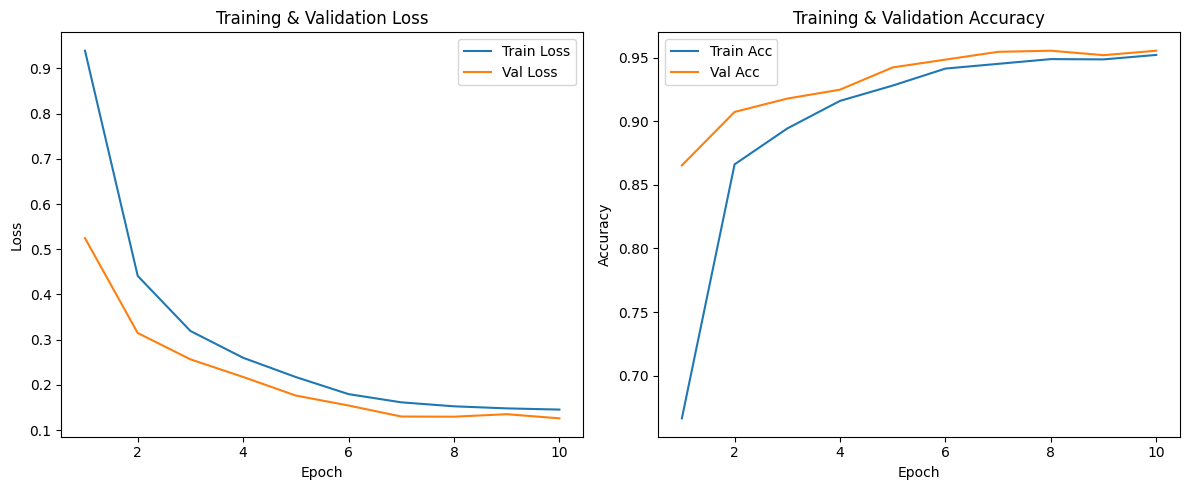

In [ ]:
epochs = range(1, len(history['train_loss']) + 1)

plt.figure(figsize=(12,5))

# Loss subplot
plt.subplot(1,2,1)
plt.plot(epochs, history['train_loss'], label='Train Loss')
plt.plot(epochs, history['val_loss'],   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Accuracy subplot
plt.subplot(1,2,2)
plt.plot(epochs, history['train_acc'], label='Train Acc')
plt.plot(epochs, history['val_acc'],   label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Testing

Classification Report:
              precision    recall  f1-score   support

      glioma       0.95      0.93      0.94       300
  meningioma       0.90      0.90      0.90       306
     notumor       0.95      0.98      0.97       405
   pituitary       0.97      0.96      0.96       300

    accuracy                           0.95      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.94      0.95      0.94      1311



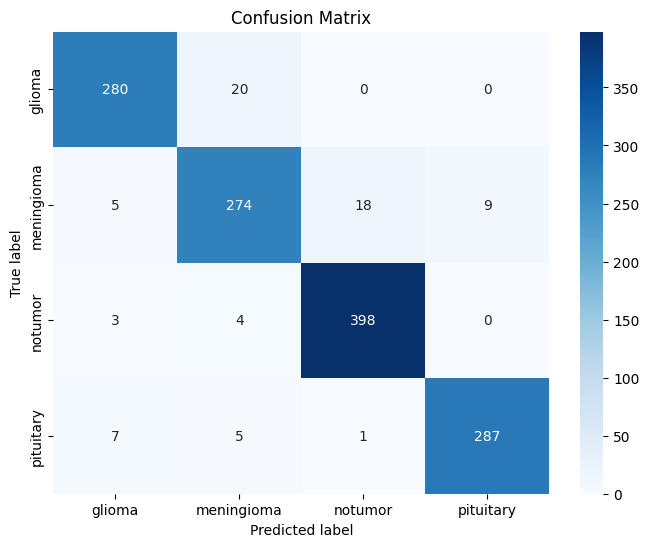

In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names,
            cmap=plt.cm.Blues)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

# Save Checkpoint

In [ ]:
torch.save(model.state_dict(), 'models/mobilenetv2_finetuned.pth')


# Heatmap generation


Uses the trained model: The Grad-CAM code takes your trained MobileNetV2 model (which was already trained in the earlier cells)
Computes gradients: When you pass an image through the model, Grad-CAM:

Does a forward pass to get predictions
Does a backward pass to compute gradients
Uses these gradients to identify which regions of the image were most important for the prediction


Generates heatmaps on-the-fly: Each time you run the Grad-CAM cells, it generates activation maps in real-time for whatever images you show it

## Import libraries

In [ ]:
import cv2
from torch.nn import functional as F
from matplotlib import cm

## Load the already trained model

In [ ]:
MODEL_PATH = "models/mobilenetv2_finetuned.pth"
# Load the saved model
num_classes = len(class_names)

# Recreate the model architecture
model = models.mobilenet_v2(pretrained=False)  # Don't need pretrained weights now
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, num_classes)

# Load the saved weights
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model = model.to(device)
model.eval()  # Set to evaluation mode

print(f"Model loaded successfully from {MODEL_PATH}")
print(f"Model is on device: {next(model.parameters()).device}")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model loaded successfully from models/mobilenetv2_finetuned.pth
Model is on device: cuda:0


## Grad-CAM Implementation

First i save the the last feature layers i want to analyze which is usually the last convulation layer.

Define the register hook that capture the activations of the forward pass(output) and the backward pass, which captures the gradients during backpropagation. The magnitude of the gradient is directly proportional to how much that feature map is important for that prediction.

To generate the CAM just multiply each activation features with the respective average gradients, the higher the gradient for that feature map the more important is that feature map for the class predicted, and that will be the most predominant region in the output CAM.

In [ ]:
class GradCAM:
    def __init__(self, model, target_layer):
        """
        Args:
            model: trained model
            target_layer: the layer to compute gradients from (e.g., model.features[-1])
        """
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate_cam(self, input_image, target_class=None):
        """
        Generate Class Activation Map
        Args:
            input_image: input tensor [1, C, H, W]
            target_class: target class index (if None, use predicted class)
        Returns:
            cam: class activation map
            pred_class: predicted class
        """
        self.model.eval()

        # Forward pass
        output = self.model(input_image)

        if target_class is None:
            target_class = output.argmax(dim=1).item()

        # Backward pass
        self.model.zero_grad()
        class_loss = output[0, target_class]
        class_loss.backward()

        # Generate CAM
        gradients = self.gradients[0]  # [C, H, W]
        activations = self.activations[0]  # [C, H, W]

        # Global average pooling of gradients
        weights = gradients.mean(dim=(1, 2))  # [C]

        # Weighted combination of activation maps
        cam = torch.zeros(activations.shape[1:], dtype=torch.float32).to(activations.device) # Fix: Initialize cam on the same device as activations
        for i, w in enumerate(weights):
            cam += w * activations[i]

        # ReLU and normalize
        cam = F.relu(cam)
        cam = cam - cam.min()
        if cam.max() != 0:
            cam = cam / cam.max()

        return cam.cpu().numpy(), target_class

def apply_colormap_on_image(org_img, activation_map, colormap=cv2.COLORMAP_JET, alpha=0.5):
    """
    Apply colormap on image
    Args:
        org_img: original image (H, W, 3) in range [0, 1]
        activation_map: activation map (H, W) in range [0, 1]
        colormap: opencv colormap
        alpha: transparency factor
    Returns:
        superimposed image
    """
    # Resize activation map to match image size
    activation_map = cv2.resize(activation_map, (org_img.shape[1], org_img.shape[0]))

    # Convert to uint8
    heatmap = cv2.applyColorMap(np.uint8(255 * activation_map), colormap)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = np.float32(heatmap) / 255

    # Superimpose heatmap on image
    cam_img = alpha * heatmap + (1 - alpha) * org_img
    cam_img = cam_img / cam_img.max()

    return cam_img

## Visualize Grad-CAM on Test Samples

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


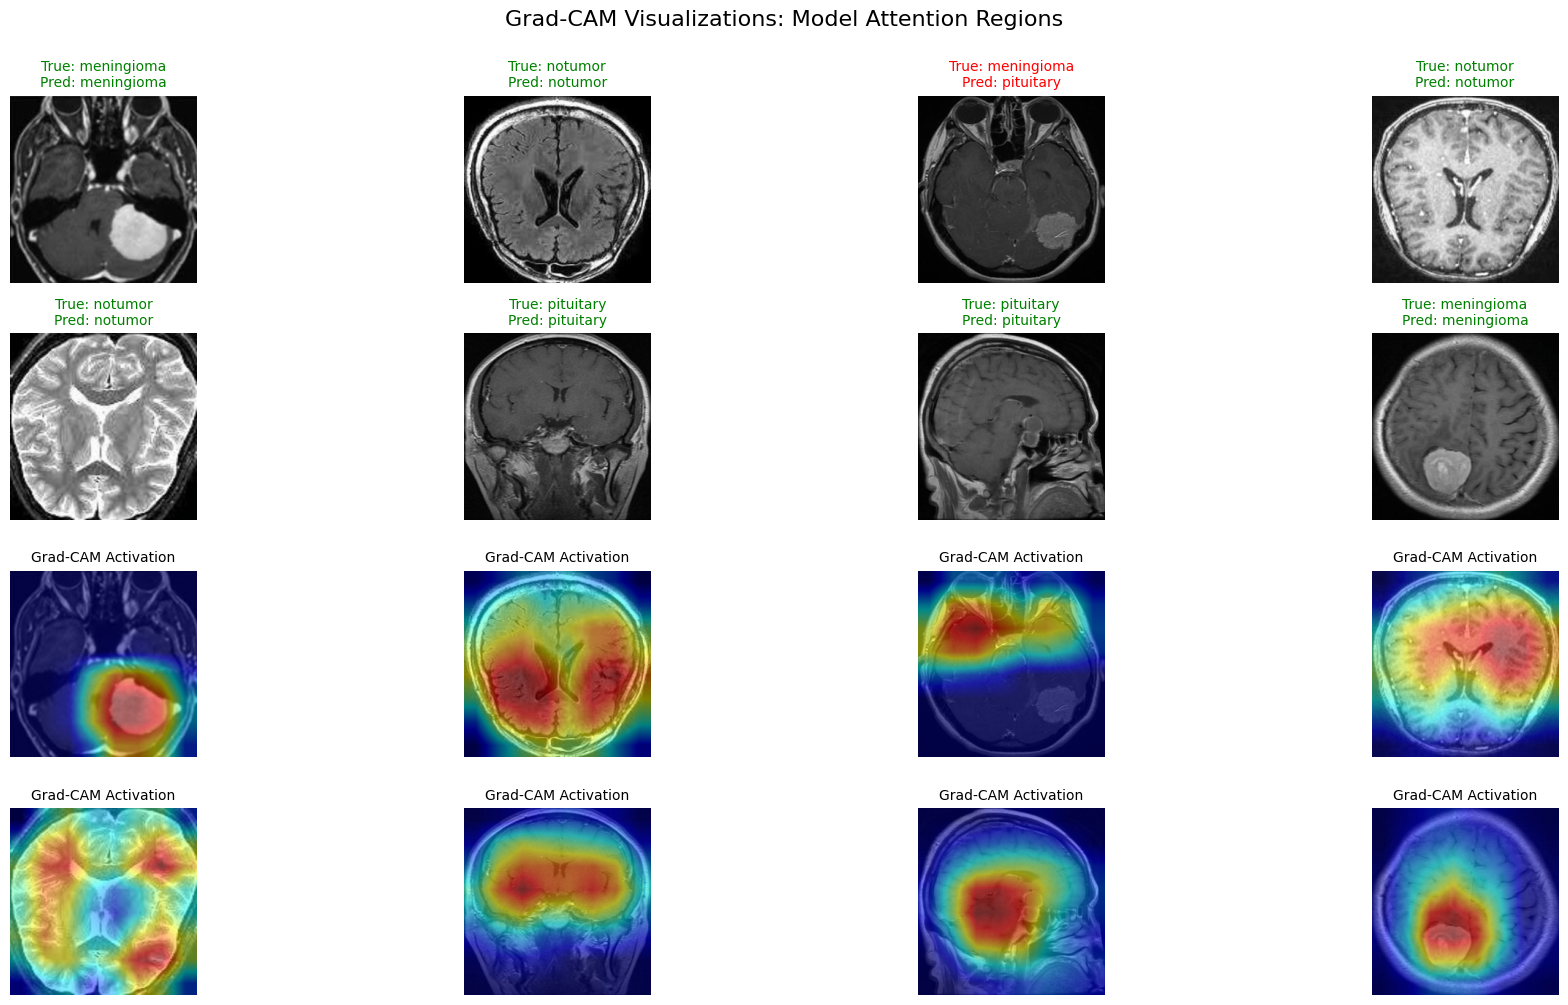

In [ ]:
# Initialize Grad-CAM with the last convolutional layer
grad_cam = GradCAM(model, target_layer=model.features[-1])

# Select random test samples to visualize
num_samples = 8
random_indices = np.random.choice(len(test_ds), num_samples, replace=False)

plt.figure(figsize=(20, 10))

for idx, sample_idx in enumerate(random_indices):
    # Get image and label
    img_tensor, true_label = test_ds[sample_idx]
    img_tensor_batch = img_tensor.unsqueeze(0).to(device)

    # Generate CAM
    cam, pred_class = grad_cam.generate_cam(img_tensor_batch)

    # ---- FIXED DENORMALIZATION ----
    img_np = img_tensor.cpu().numpy().transpose(1, 2, 0)

    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])

    # Undo normalization
    img_np = img_np * std + mean

    # Convert 0–255 → 0–1 (since Normalize was applied on uint8 images)
    img_np = img_np / 255.0

    img_np = np.clip(img_np, 0, 1)
    # --------------------------------

    # Apply colormap
    cam_img = apply_colormap_on_image(img_np, cam, alpha=0.5)

    # Plot original image
    plt.subplot(4, num_samples // 2, idx + 1)
    plt.imshow(img_np)
    plt.title(f'True: {class_names[true_label]}\nPred: {class_names[pred_class]}',
              fontsize=10, color='green' if true_label == pred_class else 'red')
    plt.axis('off')

    # Plot Grad-CAM overlay
    plt.subplot(4, num_samples // 2, idx + 1 + num_samples)
    plt.imshow(cam_img)
    plt.title('Grad-CAM Activation', fontsize=10)
    plt.axis('off')

plt.suptitle('Grad-CAM Visualizations: Model Attention Regions', fontsize=16, y=1.00)
plt.tight_layout()
plt.show()


## Analyze results

In [ ]:
# Visualize Grad-CAM for correct and incorrect predictions
model.eval()

correct_samples = []
incorrect_samples = []

# Find examples of correct and incorrect predictions
with torch.no_grad():
    for i in range(len(test_ds)):
        img, label = test_ds[i]
        img_batch = img.unsqueeze(0).to(device)
        output = model(img_batch)
        pred = output.argmax(dim=1).item()

        if pred == label and len(correct_samples) < 4:
            correct_samples.append(i)
        elif pred != label and len(incorrect_samples) < 4:
            incorrect_samples.append(i)

        if len(correct_samples) == 4 and len(incorrect_samples) == 4:
            break

# Visualize
fig, axes = plt.subplots(4, 4, figsize=(16, 16))

mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])

# ---------- CORRECT PREDICTIONS ----------
for i, sample_idx in enumerate(correct_samples):
    img_tensor, true_label = test_ds[sample_idx]
    img_tensor_batch = img_tensor.unsqueeze(0).to(device)

    cam, pred_class = grad_cam.generate_cam(img_tensor_batch)

    # ---- FIXED DENORMALIZATION ----
    img_np = img_tensor.cpu().numpy().transpose(1, 2, 0)
    img_np = img_np * std + mean     # undo normalization
    img_np = img_np / 255.0          # convert 0–255 → 0–1
    img_np = np.clip(img_np, 0, 1)
    # --------------------------------

    cam_img = apply_colormap_on_image(img_np, cam, alpha=0.5)

    axes[i, 0].imshow(img_np)
    axes[i, 0].set_title(f'Correct: {class_names[true_label]}', color='green')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(cam_img)
    axes[i, 1].set_title('Grad-CAM', color='green')
    axes[i, 1].axis('off')

# ---------- INCORRECT PREDICTIONS ----------
for i, sample_idx in enumerate(incorrect_samples):
    img_tensor, true_label = test_ds[sample_idx]
    img_tensor_batch = img_tensor.unsqueeze(0).to(device)

    cam, pred_class = grad_cam.generate_cam(img_tensor_batch)

    # ---- FIXED DENORMALIZATION ----
    img_np = img_tensor.cpu().numpy().transpose(1, 2, 0)
    img_np = img_np * std + mean     # undo normalization
    img_np = img_np / 255.0          # convert 0–255 → 0–1
    img_np = np.clip(img_np, 0, 1)
    # --------------------------------

    cam_img = apply_colormap_on_image(img_np, cam, alpha=0.5)

    axes[i, 2].imshow(img_np)
    axes[i, 2].set_title(
        f'True: {class_names[true_label]}\nPred: {class_names[pred_class]}',
        color='red', fontsize=9
    )
    axes[i, 2].axis('off')

    axes[i, 3].imshow(cam_img)
    axes[i, 3].set_title('Grad-CAM', color='red')
    axes[i, 3].axis('off')

fig.text(0.25, 0.98, 'Correct Predictions', ha='center', fontsize=14, weight='bold')
fig.text(0.75, 0.98, 'Incorrect Predictions', ha='center', fontsize=14, weight='bold')
plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

## Per class visualization

glioma
meningioma
notumor
pituitary


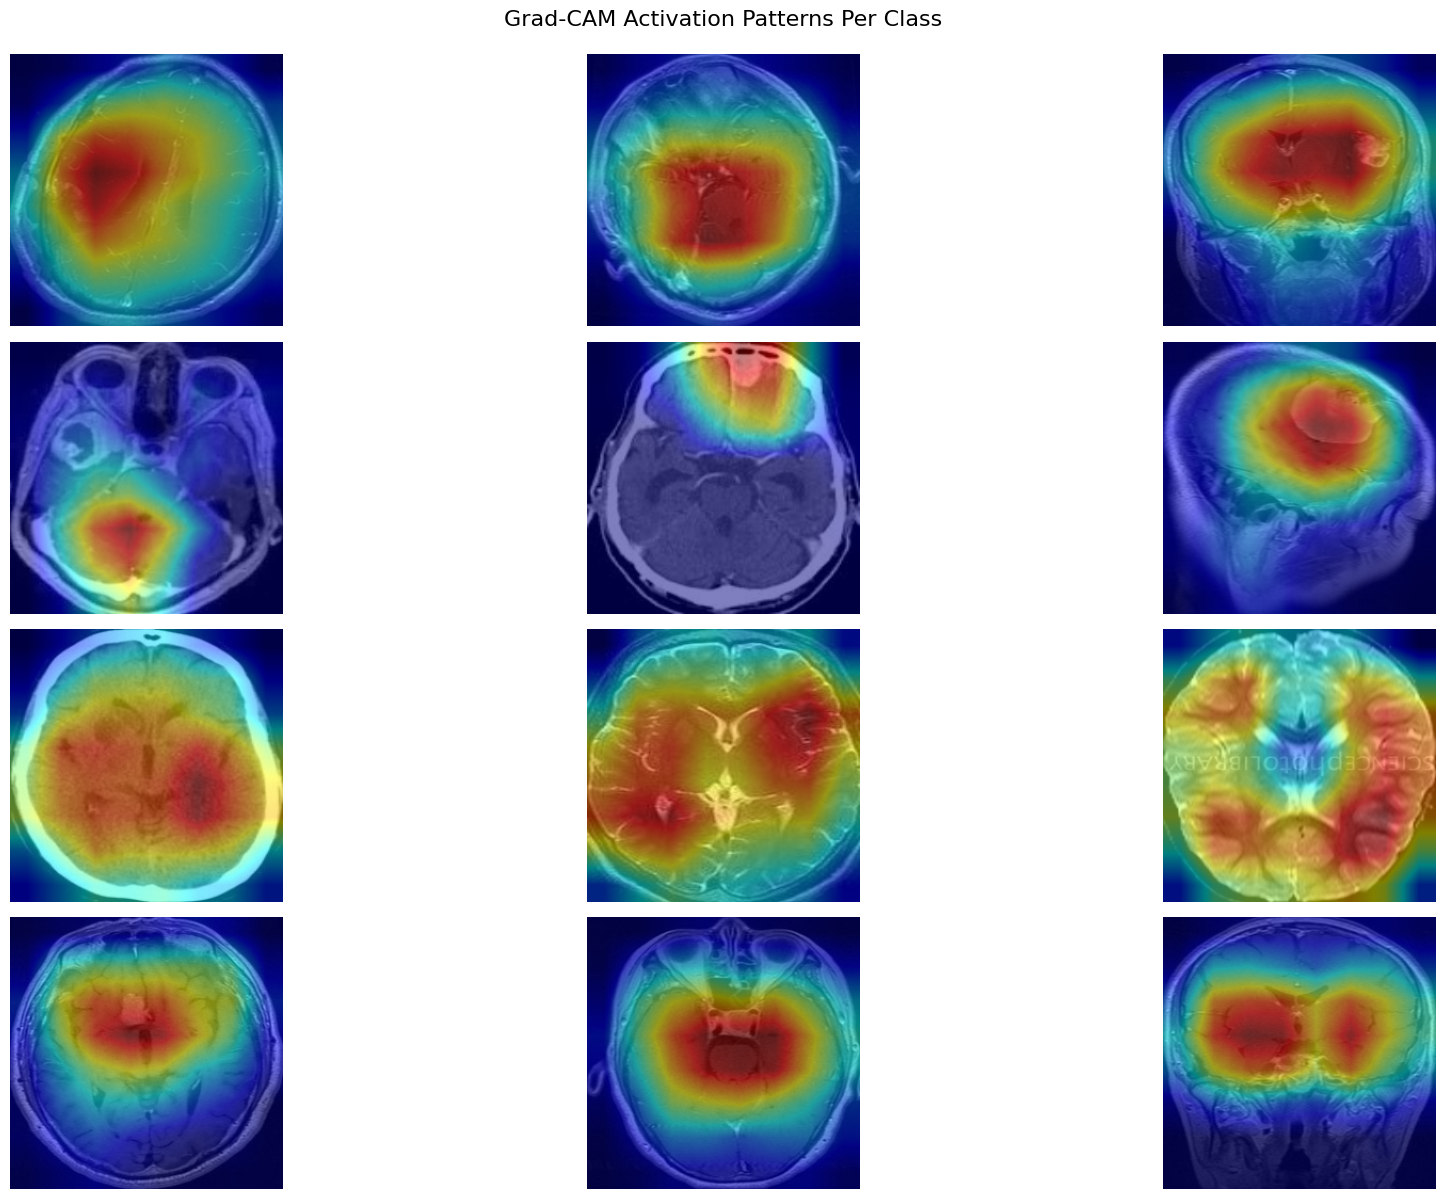

In [ ]:
# Analyze attention patterns per class
plt.figure(figsize=(20, 12))

for class_idx, class_name in enumerate(class_names):
    print(class_name)

for class_idx, class_name in enumerate(class_names):
    # Find samples of this class
    class_samples = [i for i in range(len(test_ds)) if test_ds[i][1] == class_idx][:3]

    for sample_num, sample_idx in enumerate(class_samples):
        img_tensor, true_label = test_ds[sample_idx]
        img_tensor_batch = img_tensor.unsqueeze(0).to(device)

        cam, pred_class = grad_cam.generate_cam(img_tensor_batch, target_class=class_idx)

        # ---- FIXED DENORMALIZATION ----
        img_np = img_tensor.cpu().numpy().transpose(1, 2, 0)

        mean = np.array([0.485, 0.456, 0.406])
        std  = np.array([0.229, 0.224, 0.225])

        img_np = img_np * std + mean      # undo normalization
        img_np = img_np / 255.0           # convert from 0–255 → 0–1
        img_np = np.clip(img_np, 0, 1)
        # --------------------------------

        cam_img = apply_colormap_on_image(img_np, cam, alpha=0.5)

        plt.subplot(len(class_names), 3, class_idx * 3 + sample_num + 1)
        plt.imshow(cam_img)
        if sample_num == 0:
            plt.ylabel(class_name, fontsize=12, weight='bold')
        plt.axis('off')

plt.suptitle('Grad-CAM Activation Patterns Per Class', fontsize=16, y=0.995)
plt.tight_layout()
plt.show()


## Produce Meningioma image

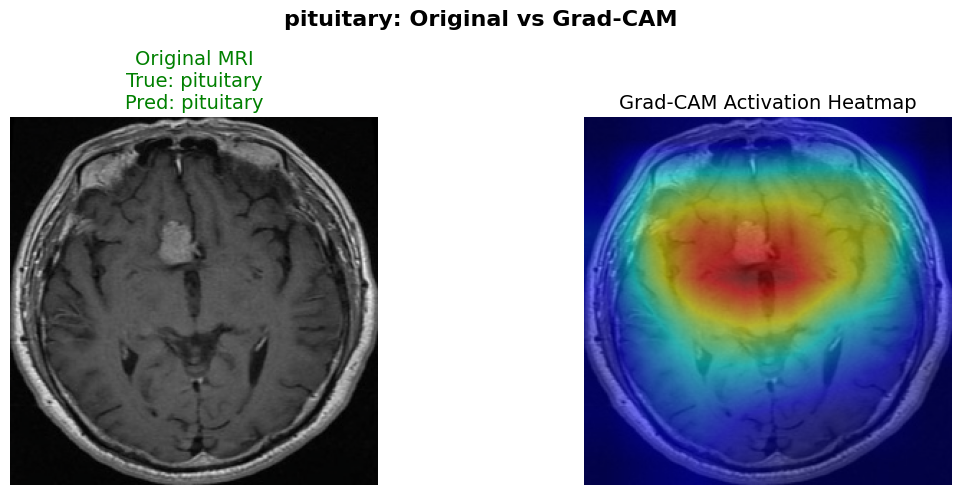

In [ ]:

# Initialize Grad-CAM with the last convolutional layer
grad_cam = GradCAM(model, target_layer=model.features[-1])

# Find a meningioma sample (class_names should have 'meningioma')
meningioma_idx = np.where(class_names == 'pituitary')[0][0]

# Find a test sample with meningioma
meningioma_samples = [i for i in range(len(test_ds)) if test_ds[i][1] == meningioma_idx]
sample_idx = meningioma_samples[0]  # Take the first meningioma sample

# Get image and label
img_tensor, true_label = test_ds[sample_idx]
img_tensor_batch = img_tensor.unsqueeze(0).to(device)

# Generate CAM
cam, pred_class = grad_cam.generate_cam(img_tensor_batch)

# ---- FIXED DENORMALIZATION ----
img_np = img_tensor.cpu().numpy().transpose(1, 2, 0)

mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])

# Undo normalization
img_np = img_np * std + mean

# Your original images were 0–255 uint8 before normalization,
# so convert correctly to 0–1 for display:
img_np = img_np / 255.0

img_np = np.clip(img_np, 0, 1)
# --------------------------------

# Apply colormap
cam_img = apply_colormap_on_image(img_np, cam, alpha=0.5)

# Plot side by side
plt.figure(figsize=(12, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(img_np)
plt.title(f'Original MRI\nTrue: {class_names[true_label]}\nPred: {class_names[pred_class]}',
          fontsize=14, color='green' if true_label == pred_class else 'red')
plt.axis('off')

# Grad-CAM overlay
plt.subplot(1, 2, 2)
plt.imshow(cam_img)
plt.title('Grad-CAM Activation Heatmap', fontsize=14)
plt.axis('off')

plt.suptitle('pituitary: Original vs Grad-CAM', fontsize=16, weight='bold')
plt.tight_layout()
plt.show()
